# Bread Baking Analysis

### Some Background
After my wife decided that we shouldn't buy white bread anymore, and I grew tired of the tired whole wheat bread from the grocery store, I made it my mission to make the best, most fluffy, whole wheat sandwhich bread ever. I have since learned many techniques, found flour and wheat varieties that work better for bread, and scoured the internet for tips on how to improve my bread. 

While on my journey to find the best whole wheat sandwhich bread, I frequently came across recipes that included a tablespoon of lemon juice for which the claim was that it would optimize the ph level in the bread for better yeast activity. I was immediately sceptical of this idea, but like any good statistician, I decided to put it to the test.

### The Experiment Design
If the lemon juice really did improve the yeast activity in the bread, I wasn't sure how it would affect the rising time, so I decided to test two different rising times: 60 and 45 minutes. This made a total of 4 unique treatment combinations. I made 3 "batches" meaning that the bread was mixed risen and baked at the same time (although in different mixers) to make a total of 12 experimental units.

The treatments were randomly assigned to a mixer-baker pair for each batch and enough dough was mixed for a single loaf of bread from each mixer. All of the ingredients were pre measured to ensure that they all recieved the exact same amount of everything. The flour was weighed so that each experimental unit recieved the same amount of flour. The only difference being that some of them had lemon juice while some of them did not.

The mixers being used for the experiment were all Bosche Universal Plus mixers, although two of the four were an older model, I believe that the variance due to mixer is negligible.

Our chosen measure of "fluffiness" was bread perimeter. We used a flexible measureing tape to measure the perimeter of the center of the loaf of bread in centimeters. In an attempt to reduce variability, we also flattened the dough in the loaf pan just after shaping the bread.

In [1]:
import pandas as pd
import pymc as pm
import arviz as az
from plotnine import *
from scipy import stats
import matplotlib.pyplot as plt
import pytensor.tensor as pt
import numpy as np
import pickle
theme_set(theme_bw())

## Exploratory Data Analysis

In [ ]:
bread = pd.read_csv("bread_stat.csv") \
    .assign(Time = lambda x: pd.Categorical(x.Time)) \
    .assign(Batch = lambda x: pd.Categorical(x.Batch))

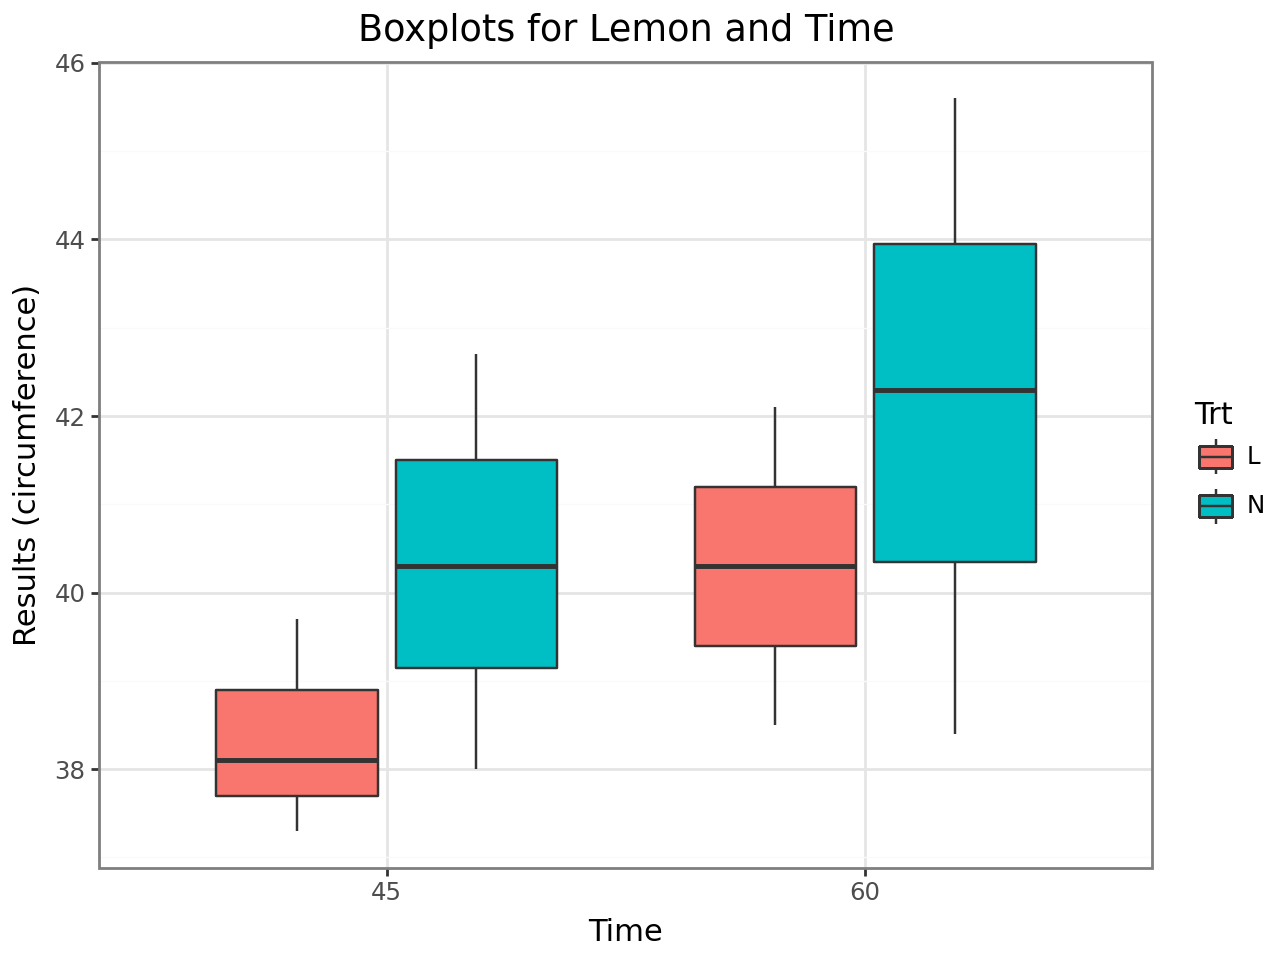

In [14]:
ggplot(bread) \
+ geom_boxplot(aes(x = "Time", fill = "Trt", y = "Results (circumference)")) \
+ labs(
    title = "Boxplots for Lemon and Time"
)

From the data we can see a clear distincting in the treatment groups, it looks like for each level of rising time, the Lemon juice actually had an adverse effect on the bread perimeter.

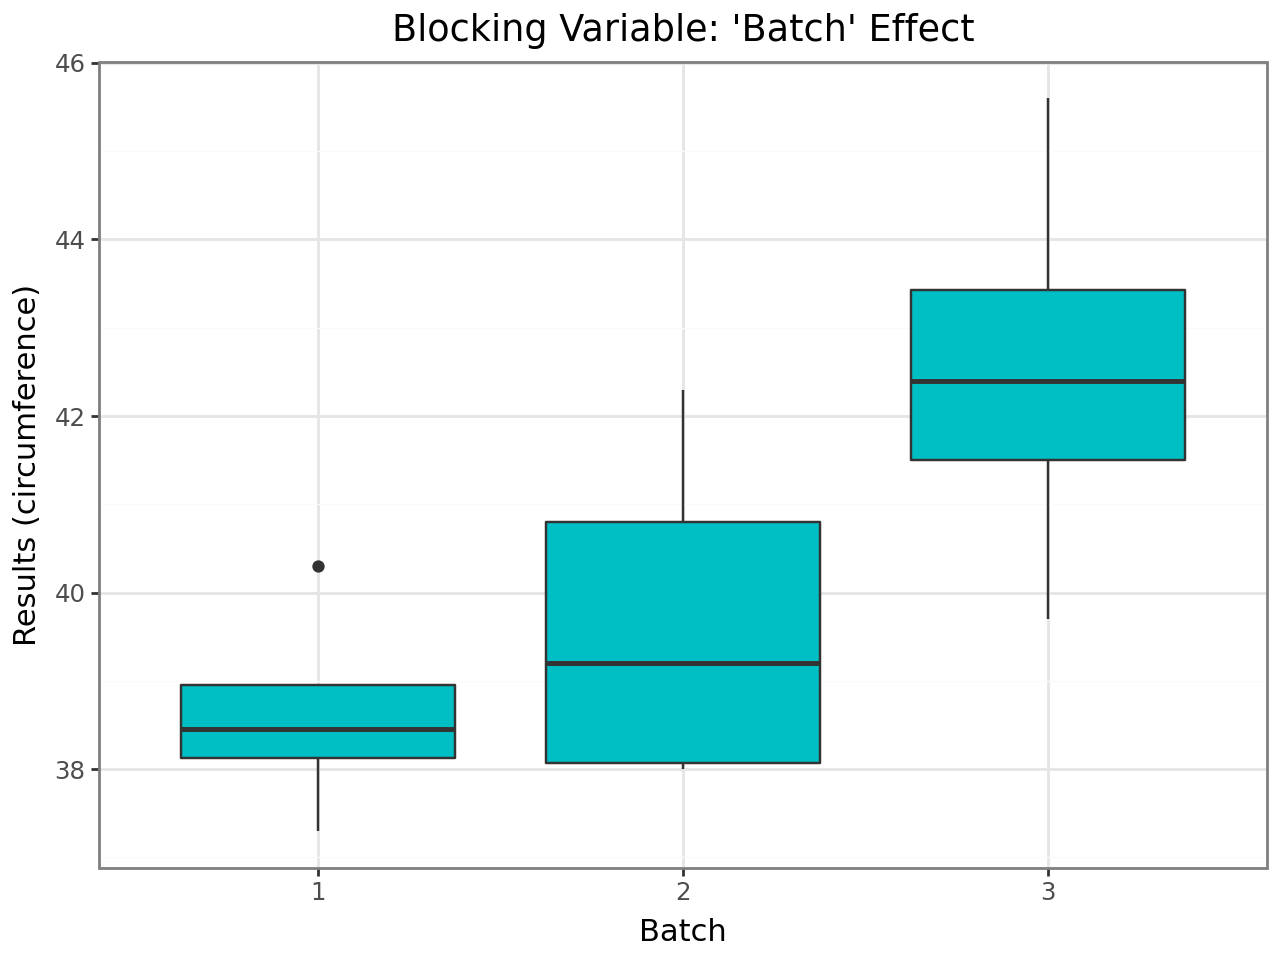

In [15]:
ggplot(bread) \
+ geom_boxplot(aes(x = "Batch", y = "Results (circumference)"),
               fill = "#00bfc4") \
+ labs(
    title = "Blocking Variable: 'Batch' Effect"
)

It looks like our blocking variable did have sufficient variability. We will include it in our analysis.

## Data Analysis

### Data Preparation

In [3]:
# Data processing and "book keeping" for modeling
dat = bread \
    .assign(trt_idx = lambda x: pd.factorize(x.Trt)[0]) \
    .assign(time_idx = lambda x: pd.factorize(x.Time)[0]) \
    .assign(batch_idx = lambda x: pd.factorize(x.Batch)[0]) \
    .rename({"Results (circumference)" : "Y"}, axis = 1) \
    .assign(obs_id = range(bread.shape[0])) \
    [["Time", "Trt", "trt_idx", "time_idx", "Batch", "batch_idx", "Y", "obs_id"]]

### Investigate Potential Prior Distributions

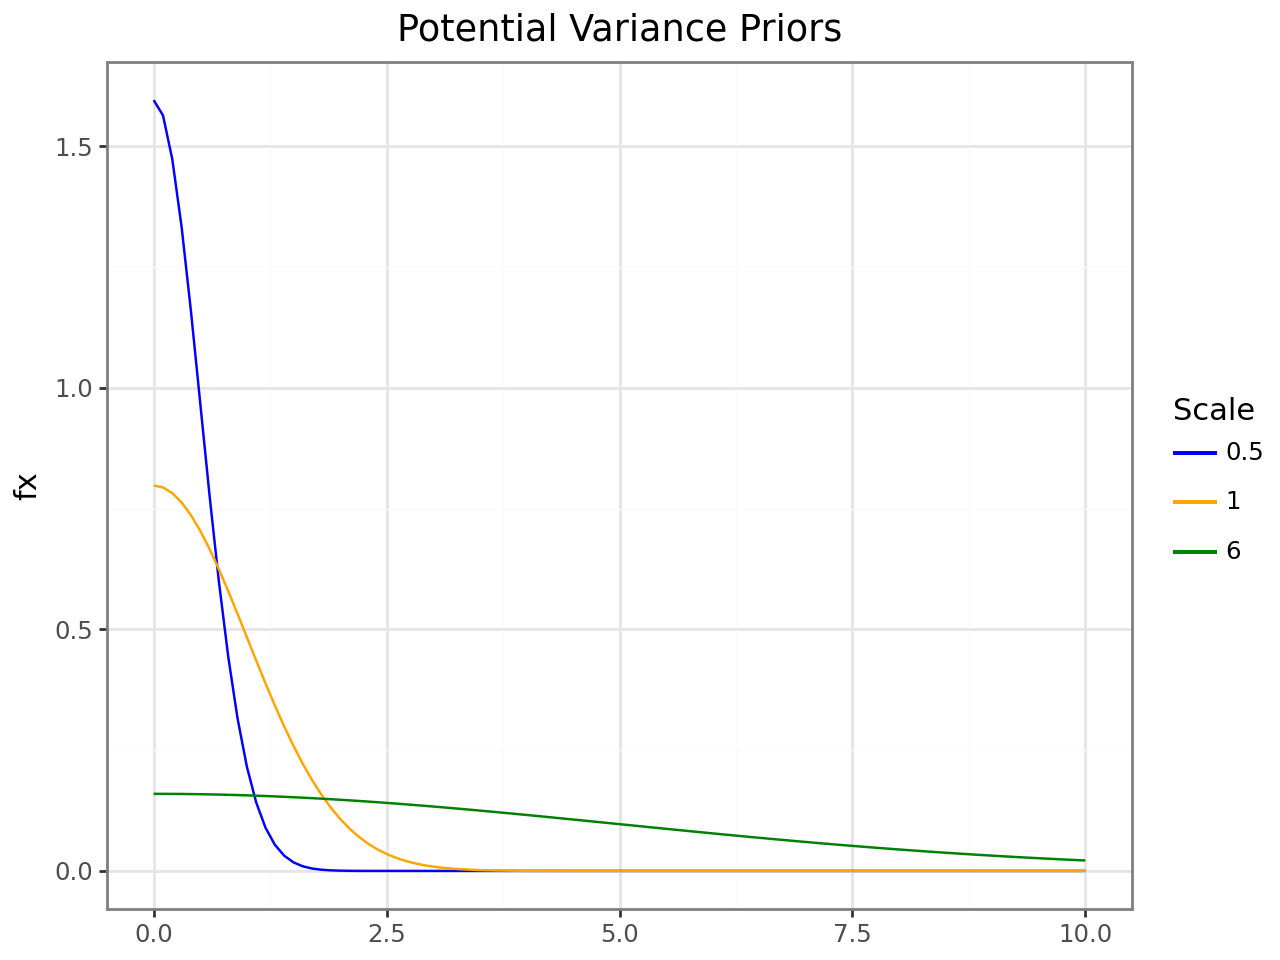

In [3]:
# Visualize some of the prior distributions
ggplot() \
+ stat_function(fun = stats.halfnorm.pdf, args = {"scale" : 0.5},
                mapping = aes(color = "'0.5'")) \
+ stat_function(fun = stats.halfnorm.pdf, args = {"scale" : 1},
                mapping = aes(color = "'1'")) \
+ stat_function(fun = stats.halfnorm.pdf, args = {"scale" : 5},
                mapping = aes(color = "'6'")) \
+ xlim(0, 10) \
+ scale_color_manual(labels = ["0.5", "1", "6"],
                     values = ["blue", "orange", "green"],
                     name = "Scale") \
+ theme_bw() \
+ labs(
    title = "Potential Variance Priors"
)

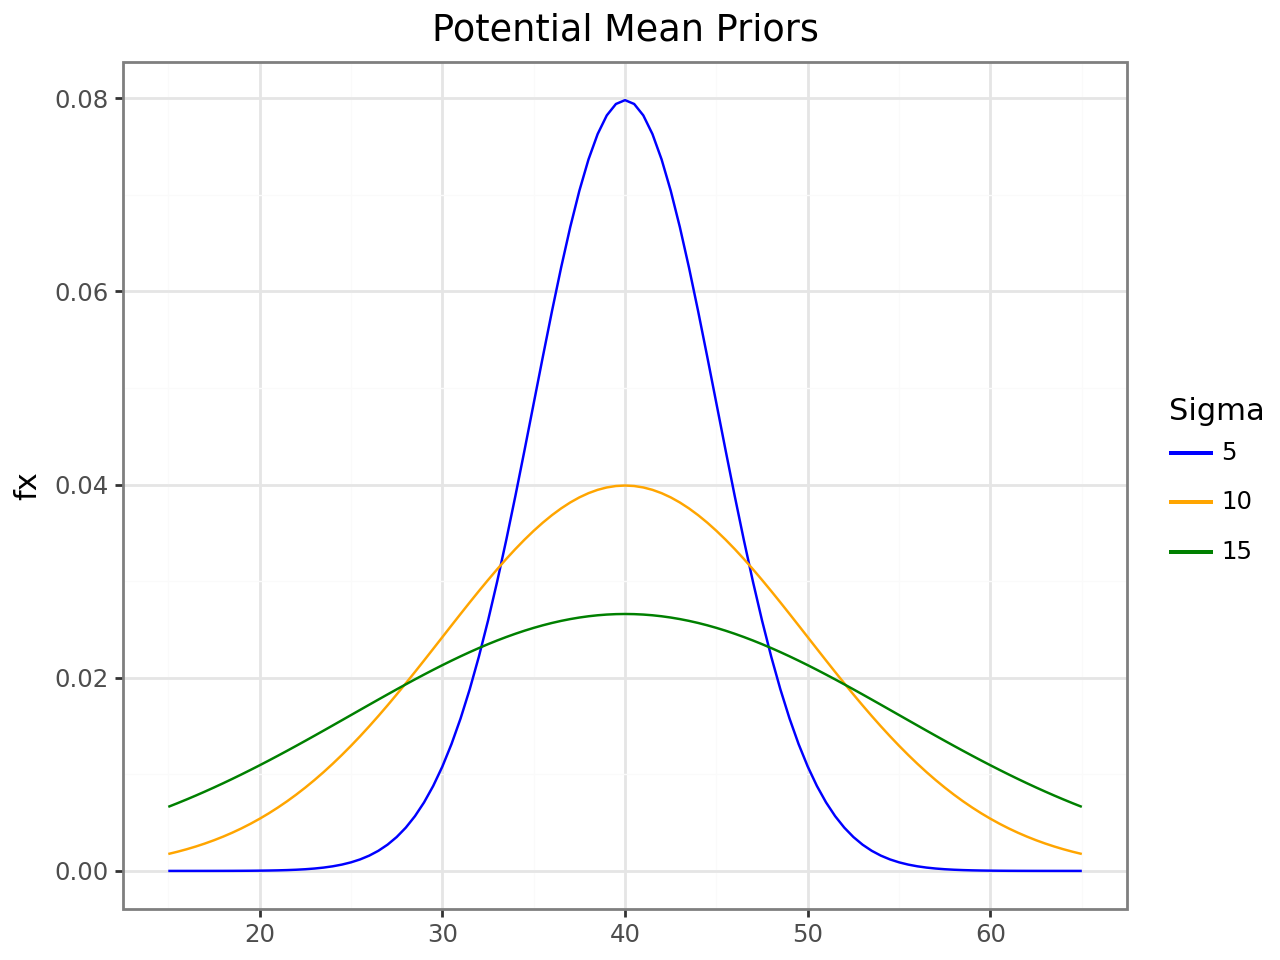

In [10]:
# Investigate priors for the mean
ggplot() \
+ xlim(15, 65) \
+ stat_function(fun = stats.norm.pdf, args = {"loc" : 40, "scale" : 5},
                mapping=aes(color = "'5'")) \
+ stat_function(fun = stats.norm.pdf, args = {"loc" : 40, "scale" : 10},
                mapping=aes(color = "'10'")) \
+ stat_function(fun = stats.norm.pdf, args = {"loc" : 40, "scale" : 15},
                mapping=aes(color = "'15'")) \
+ scale_color_manual(labels = ["5", "10", "15"],
                     values = ["blue", "orange", "green"],
                     name = "Sigma") \
+ labs(
    title = "Potential Mean Priors"
)

The lowest possible value for the mean bread perimeter is the perimeter of the raw dough which comes to about 25-30 cm, and the largest that it could be would be about 70 cm as this would be more than double the original dough. Because of that, I chose a prior for the cell means of a normal distribution centered at 40 with a standard deviation of 10 which I think is reasonable uninformative while capturing the range of plausible values.

My priors for the variance parameters I made to be a half normal distribution with sigma equal to 6 because I believe it to be a relatively uninformative prior and having spent a lot of time baking bread, there tends to be low variability between batches, most of the time it is down to less than 5 centimeters difference in perimeter.

### Model Formulation

In [28]:
coords = {
    "time" : ["60", "45"],
    "treatment" : ["L", "N"],
    "batch" : ["1", "2", "3"],
    "obs_id" : list(range(dat.shape[0]))
}

with pm.Model(coords = coords) as bread_model:
    # Define Data
    trt_idx = pm.Data("trt_idx", dat["trt_idx"], dims="obs_id")
    time_idx = pm.Data("time_idx", dat["time_idx"], dims="obs_id")
    batch_idx = pm.Data("batch_idx", dat["batch_idx"], dims="obs_id")
    Y_dat = pm.Data("Y_dat", dat["Y"], dims="obs_id")

    # Variance Components
    sigma_b = pm.HalfNormal("sigma_batch", sigma = 5)
    sigma_e = pm.HalfNormal("sigma_e", sigma = 5)

    # Fixed Effect Priors
    means = pm.Normal("cell_means", mu = 40, sigma = 10,
                      dims = ["time", "treatment"])

    # Random Effect Prior
    batch_eff_offset = pm.Normal(name = "batch_eff_offset", mu = 0, sigma = 1, dims="batch")
    batch_eff = pm.Deterministic("batch_eff", batch_eff_offset * sigma_b)

    # Define the model
    mu = means[time_idx, trt_idx] + batch_eff[batch_idx]

    # Define the Likelihood
    Y_obs = pm.Normal("Y_obs", mu = mu, sigma = sigma_e, observed = Y_dat, dims="obs_id")

Due to some initial divergences, I used a high number of sample and a high value for target_accept to ensure a stable and accurate posterior distribution.

In [45]:
with bread_model:
    idata = pm.sample(
        draws=40000,
        tune=10000,
        target_accept = 0.999,
        progressbar = "split",
        idata_kwargs = {"log_likelihood" : True}
    )

c:\Users\rileyw\anaconda3\envs\pymc_env\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_batch, sigma_e, cell_means, batch_eff_offset]


Output()

Sampling 4 chains for 10_000 tune and 40_000 draw iterations (40_000 + 160_000 draws total) took 1013 seconds.


In [ ]:
# Save Inference Data object so that we don't have to run the model again
idata.to_netcdf("bread_results.nc")

'bread_results.nc'

In [2]:
# Read in the netcdf object
idata = az.from_netcdf("bread_results.nc")

### Model Validation

#### Model Convergence

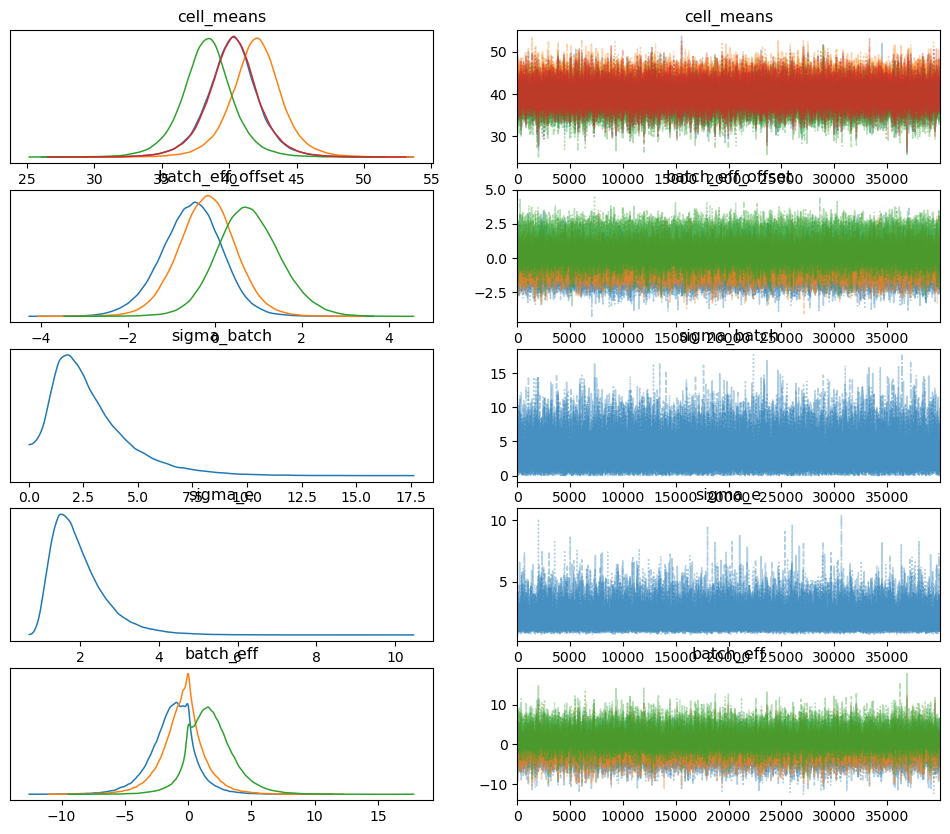

In [49]:
plt.close("all")
az.plot_trace(idata, combined = True)
plt.show()

In [5]:
post_summary = az.summary(idata, round_to=2)
print(post_summary[["mean", "ess_bulk", "ess_tail", "r_hat"]])

                      mean  ess_bulk  ess_tail  r_hat
cell_means[60, L]    40.25  30827.54  39345.77    1.0
cell_means[60, N]    42.02  30975.81  39695.78    1.0
cell_means[45, L]    38.34  30267.29  39519.37    1.0
cell_means[45, N]    40.28  30035.88  38913.35    1.0
batch_eff_offset[1]  -0.55  35666.24  53917.19    1.0
batch_eff_offset[2]  -0.19  37736.22  62365.44    1.0
batch_eff_offset[3]   0.78  34361.26  49549.46    1.0
sigma_batch           2.75  22122.39  24019.89    1.0
sigma_e               1.95  29308.66  51901.28    1.0
batch_eff[0]         -1.24  26750.85  36352.86    1.0
batch_eff[1]         -0.42  27626.13  36429.00    1.0
batch_eff[2]          1.79  25395.80  34983.10    1.0


Looking at the trace plots, we can see no clear divergences or differences in the convergence of each chain. Additionally, the r-hat values for each parameter are 1 which shows that the chains all converged appropriately. 

We can also see from the output that the effective sample size is more than high enough for us to proceed with the analysis.

#### Assumptions

##### Normality

In [ ]:
# Get the Posterior Predictive Distribution
pm.sample_posterior_predictive(idata, model=bread_model, extend_inferencedata=True)

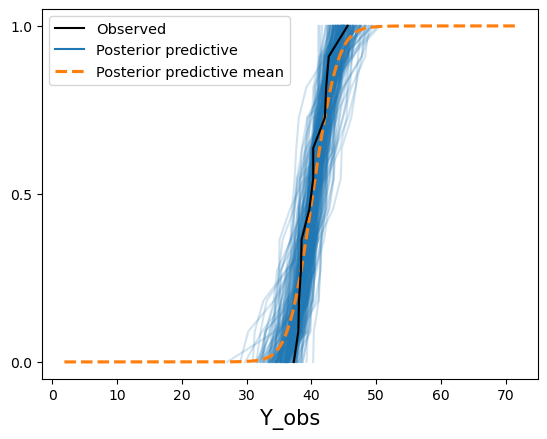

In [37]:
az.plot_ppc(idata, num_pp_samples=200, kind="cumulative")
plt.show()

Our data (the black line) looks like it could have reasonably come from this distribution, so I think that our normality assumption is justified and reasonable.

c:\Users\rileyw\anaconda3\envs\pymc_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


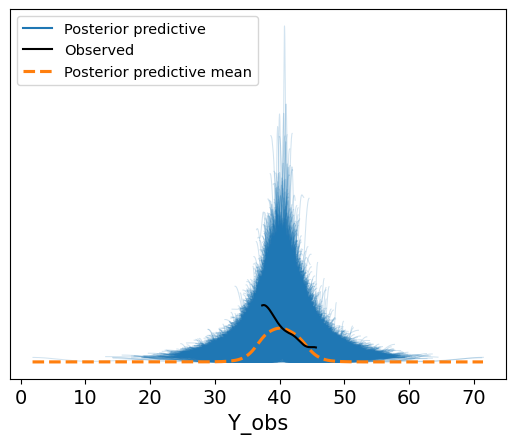

In [ ]:
az.plot_ppc(idata, num_pp_samples=50)
plt.show()

##### Equal Variance

In [42]:
residuals = idata.observed_data.Y_obs - idata.posterior_predictive["Y_obs"]
residuals = residuals.stack(sample = ("draw", "chain"))
fitted = idata.posterior_predictive["Y_obs"]
fitted = fitted.stack(sample = ("draw", "chain"))

In [43]:
estimated_resids = residuals.mean(axis = 1)
fitted_vals = fitted.mean(axis = 1)

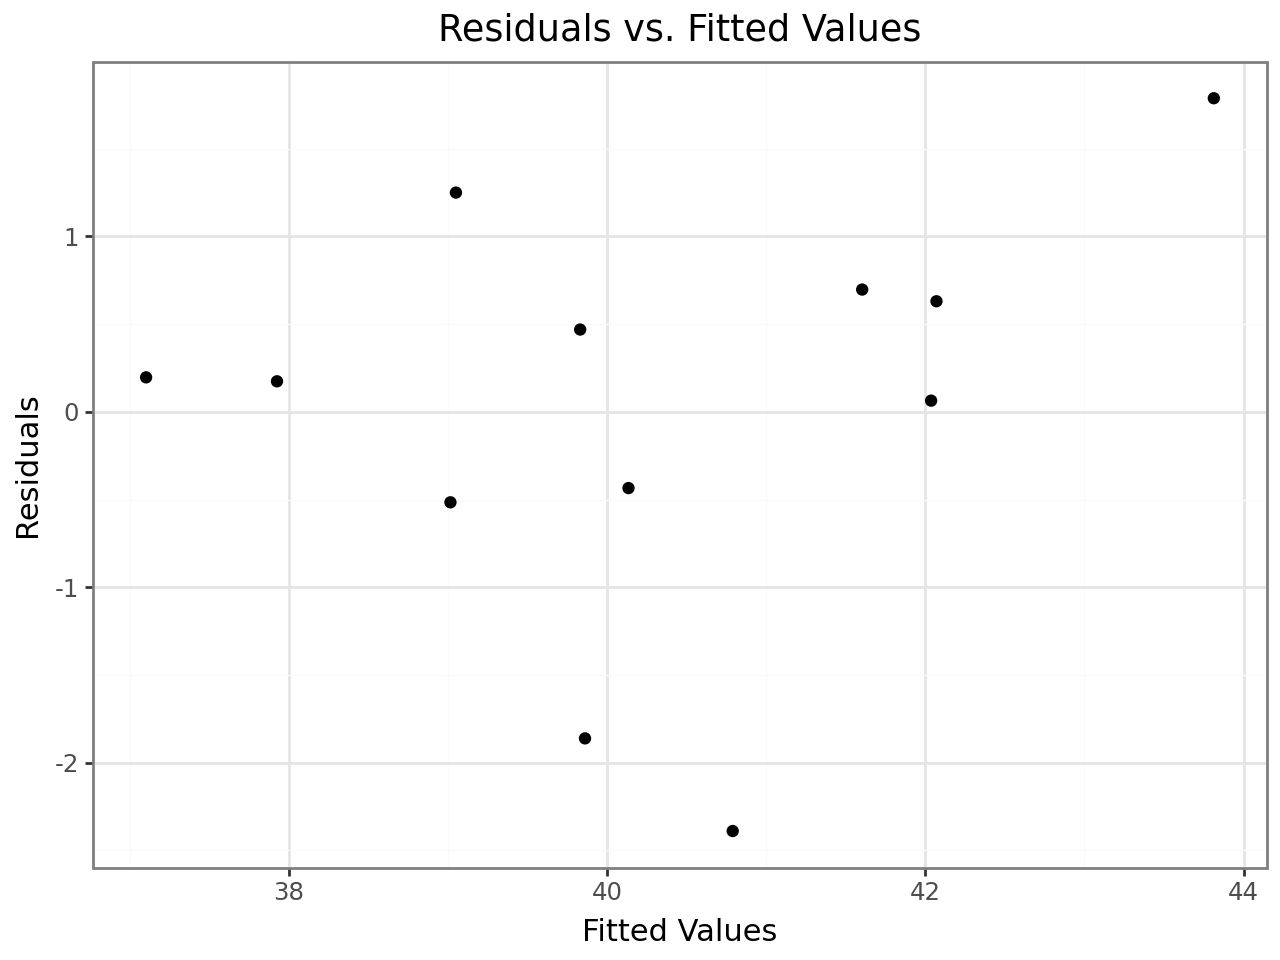

In [45]:
ggplot() \
+ geom_point(aes(x = "fitted_vals", y = "estimated_resids")) \
+ labs(
    title = "Residuals vs. Fitted Values",
    x = "Fitted Values",
    y = "Residuals"
)

Although it does look like there might be some sort of structure, I think that this is simply due to randomness and our low sample size, I think that the assumption of equal variance is satisfied.

## Inference

In [3]:
means = idata.posterior["cell_means"] \
    .stack(sample = ["draw", "chain"],
           cell = ["time", "treatment"])
col_names = [str(i) + ":" + str(j) for i, j in means.cell.values]
means_df = pd.DataFrame(means.values, columns=col_names)
long_df = means_df.melt(var_name="Treatment", value_name="Bread Perimeter")

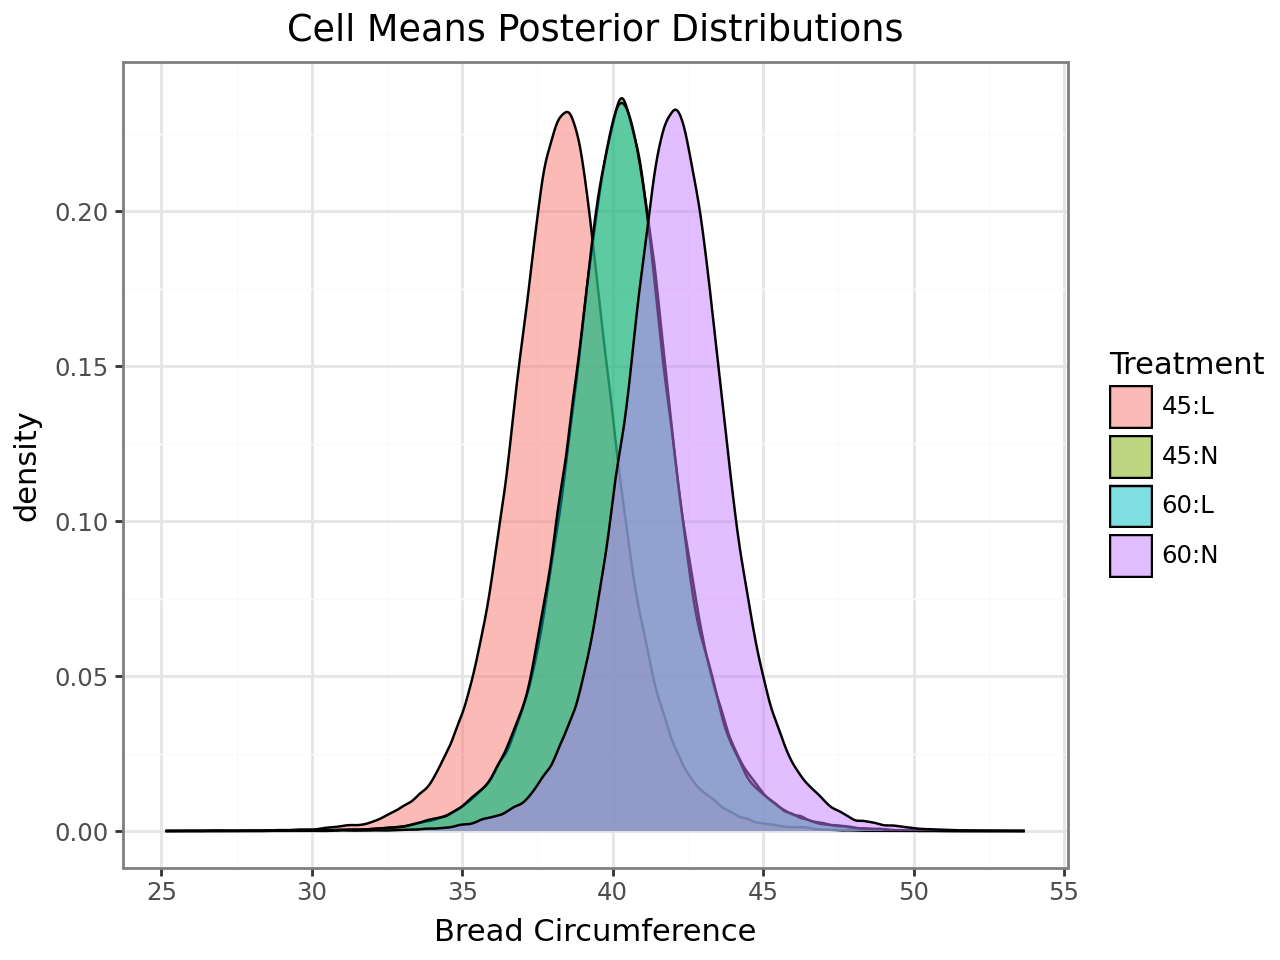

In [ ]:
ggplot(long_df) \
+ geom_density(aes(x = "Bread Perimeter", fill = "Treatment"),
               alpha = 0.5) \
+ labs(
    title = "Cell Means Posterior Distributions"
)

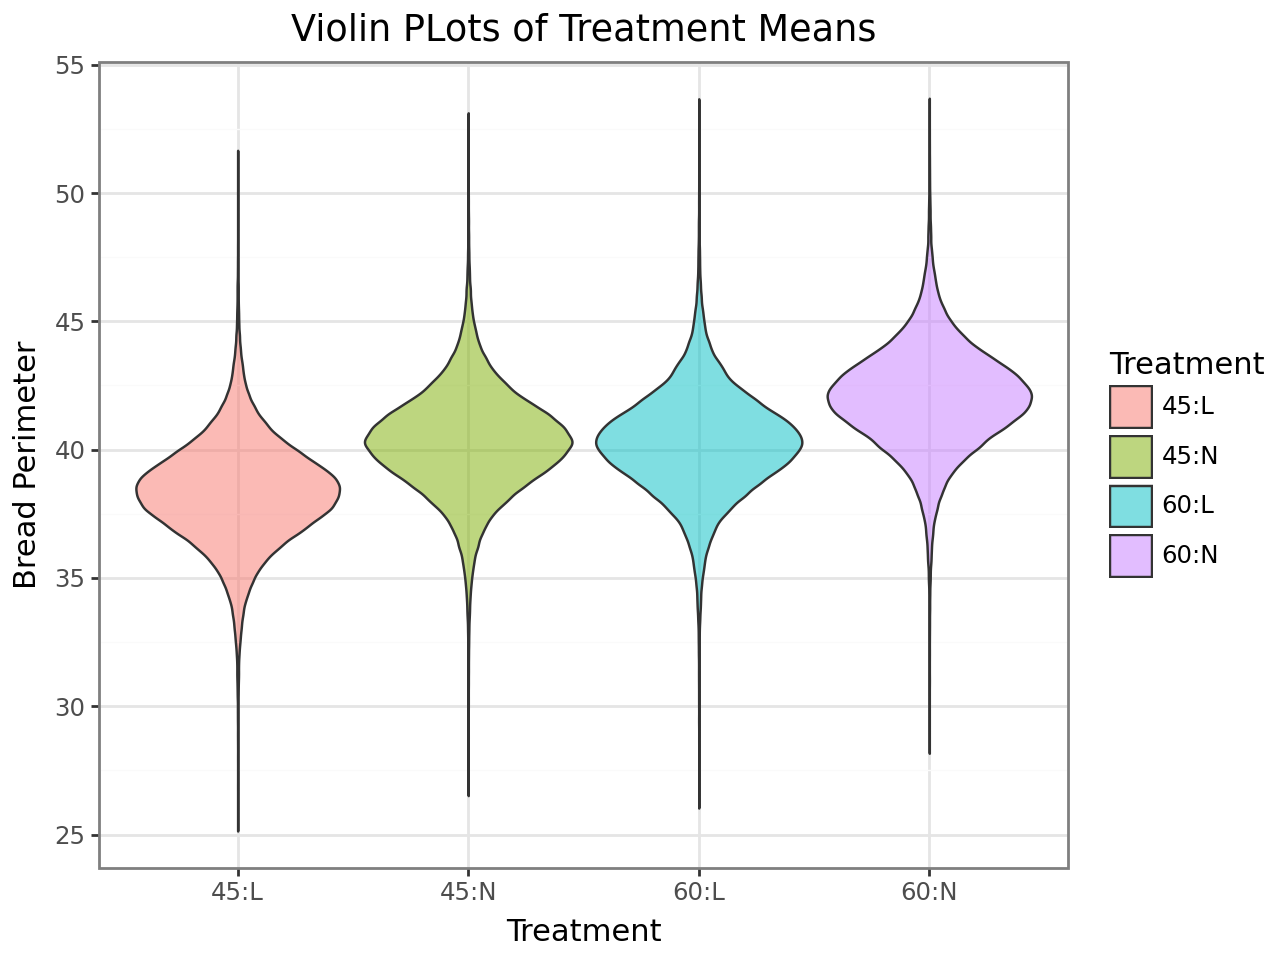

In [49]:
ggplot(long_df) \
+ geom_violin(aes(x = "Treatment", y = "Bread Perimeter", fill = "Treatment"),
               alpha = 0.5) \
+ labs(
    title = "Violin PLots of Treatment Means"
)

### Effects

In [5]:
means.cell.values

array([('60', 'L'), ('60', 'N'), ('45', 'L'), ('45', 'N')], dtype=object)

In [4]:
# Define Contrasts for effects
time_effect = [0.5, 0.5, -0.5, -0.5]
lemon_effect = [0.5, -0.5, 0.5, -0.5]
interaction = [1, -1, -1, 1]

C = np.array([time_effect, lemon_effect, interaction])

In [5]:
# Get Posterior Distributions for each of the effects
C_dist = means.values @ C.T

# Calculate 94% Credible Intervals
time_interval = az.hdi(C_dist[:,0])
lemon_interval = az.hdi(C_dist[:,1])
interaction_interval = az.hdi(C_dist[:,2])
print(f"94% Time Credible Interval: {time_interval}")
print(f"94% Lemon Credible Interval: {lemon_interval}")
print(f"94% Interaction Credible Interval: {interaction_interval}")

94% Time Credible Interval: [-0.42129821  4.09331833]
94% Lemon Credible Interval: [-4.10779742  0.40613947]
94% Interaction Credible Interval: [-4.19106796  4.78034615]


There is no clear interaction effect, so we can interpret the main effects overall.

#### Does rising time affect bread circumference?

In [17]:
class geom_density_highlight(geom_density):
    # new method
    def __init__(self, *args, region=(-np.inf, np.inf), **kwargs):
        super().__init__(*args, **kwargs)
        self.region = region

    def setup_data(self, data):
        data = super().setup_data(data)
        s = f"{self.region[0]} <= x <= {self.region[1]}"  # new line
        data = data.query(s).reset_index(drop=True)  # new line
        return data

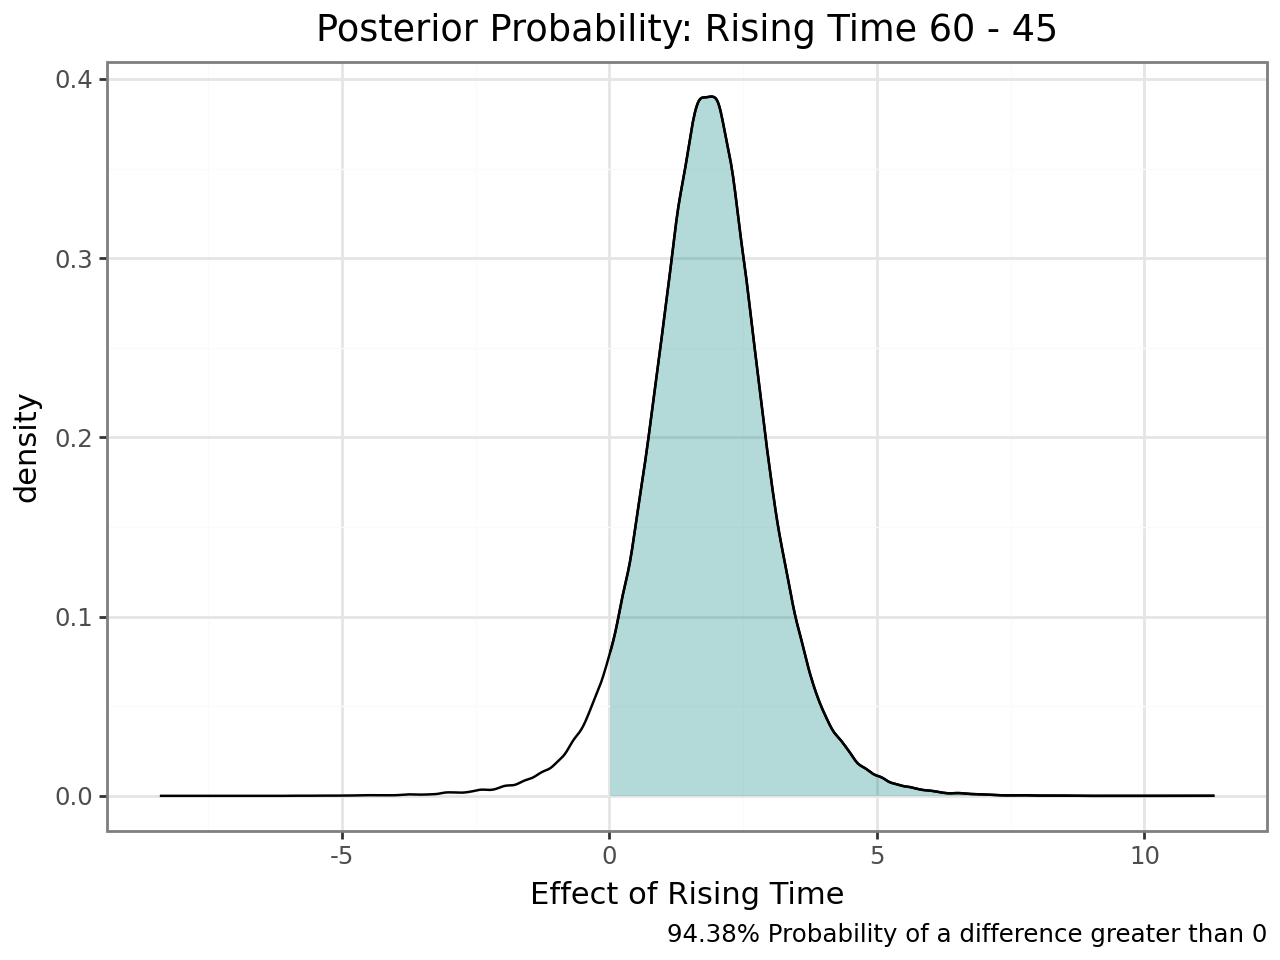

In [ ]:
prob = (C_dist[:,0] > 0).mean()

ggplot(aes(x = "C_dist[:,0]")) \
+ geom_density_highlight(region = (0, np.inf), 
                         fill = "teal", 
                         alpha =0.3) \
+ geom_density() \
+ labs(
    title = "Posterior Probability: Rising Time 60 - 45",
    x = "Effect of Rising Time",
    caption=str(round(prob*100, 2)) + "% Probability of a difference greater than 0"
)


We calculated a 0.9438 posterior probability given our data and prior knowledge that when we let the bread rise for 60 minutes it will have a larger perimeter than bread that we let rise for 45 minutes.

In [6]:
print(f"94% Time Credible Interval: {time_interval}")

94% Time Credible Interval: [-0.42129821  4.09331833]


A 94% high density credible interval shows that there is a 94% probability that the true mean difference between the bread circumferences or "fluffyiness" is between -0.42 and 4.09 cm.

#### Does adding lemon juice affect bread perimeter?

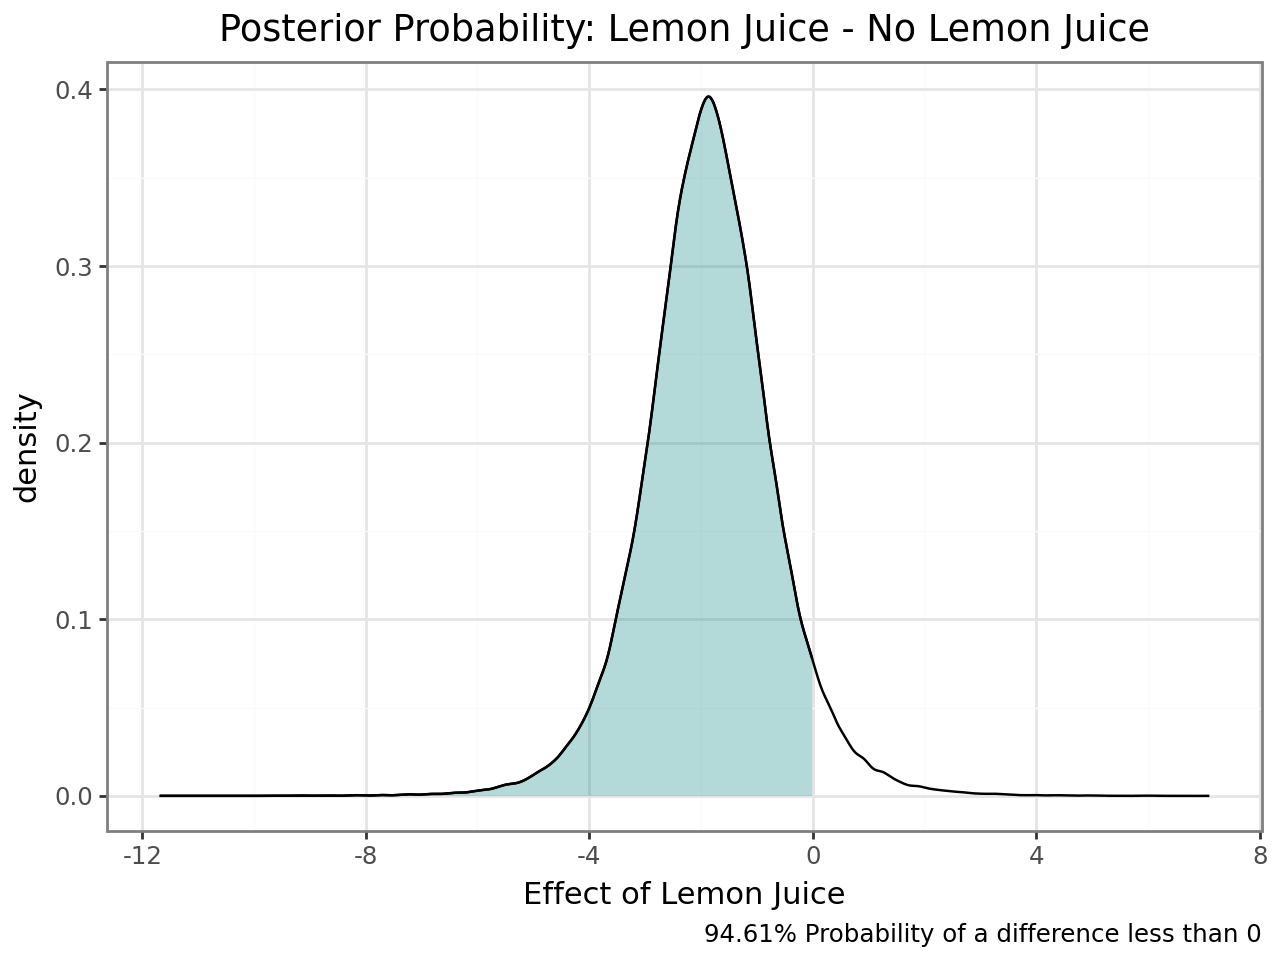

In [23]:
prob = (C_dist[:,1] < 0).mean()

ggplot(aes(x = "C_dist[:,1]")) \
+ geom_density_highlight(region = (-np.inf, 0), 
                         fill = "teal", 
                         alpha =0.3) \
+ geom_density() \
+ labs(
    title = "Posterior Probability: Lemon Juice - No Lemon Juice",
    x = "Effect of Lemon Juice",
    caption=str(round(prob*100, 2)) + "% Probability of a difference less than 0"
)

I calculated a 0.9461 probability that Lemon Juice decreases the bread circumference which means that lemon juice likely is making the bread worse! Contrary to what you might read online.

In [7]:
print(f"94% Lemon Credible Interval: {lemon_interval}")

94% Lemon Credible Interval: [-4.10779742  0.40613947]


There is a 94% posterior probability given our data and prior knowledge that the true mean difference lies between -4.11 and 0.41 cm

#### Random Effects

In [33]:
# Retrieve the Posterior Distribution for Sigma_Batch
sigma_batch = idata.posterior["sigma_batch"] \
    .stack(samples = ("draw", "chain")) \
    .values

# Retrieve the Posterior Distribution for Sigma_e
sigma_e = idata.posterior['sigma_e'] \
    .stack(samples = ("draw", "chain")) \
    .values

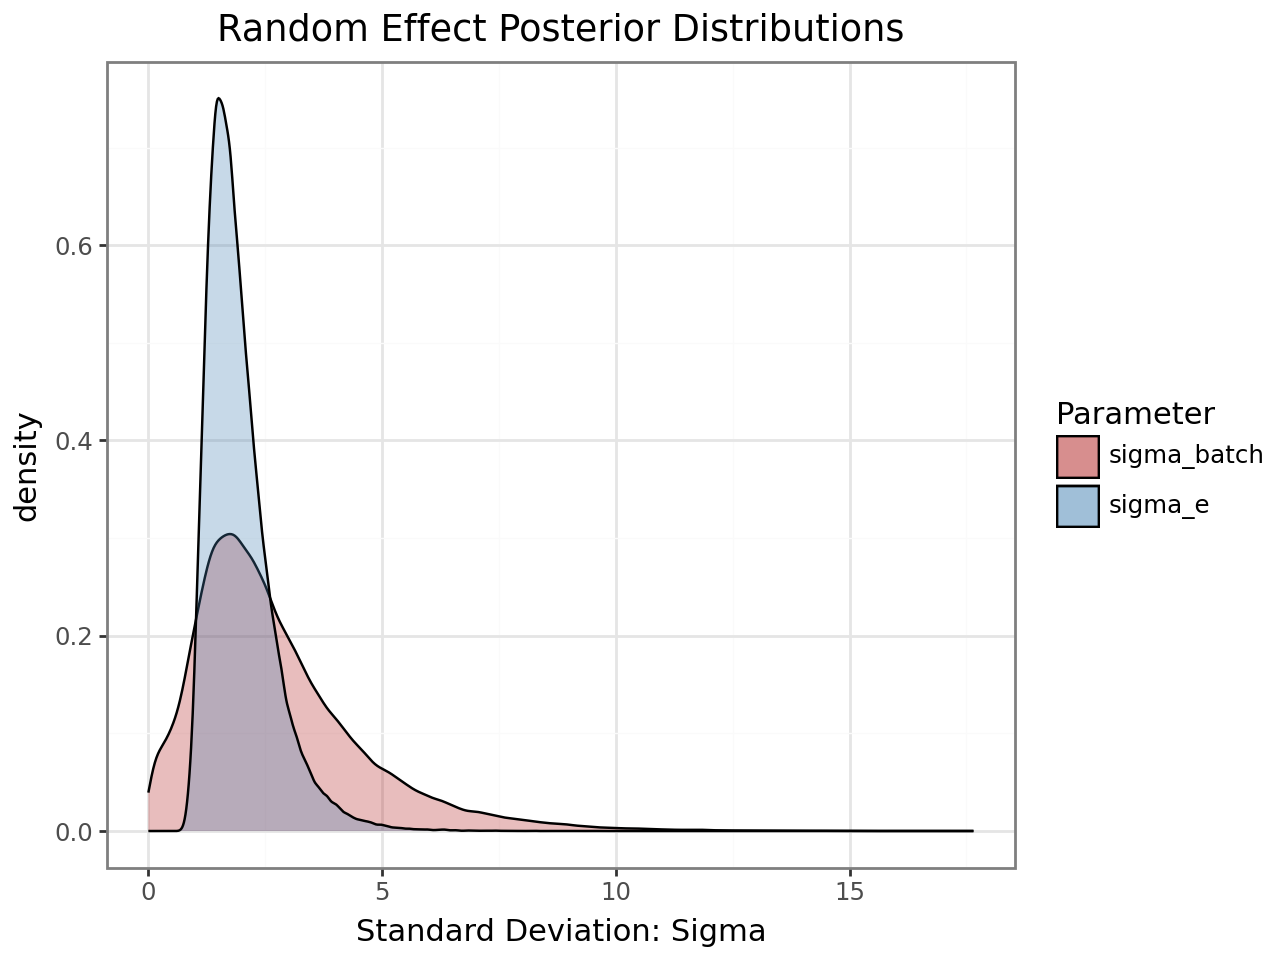

In [40]:
ggplot() \
+ geom_density(aes(x = "sigma_batch", fill = "'sigma_batch'"),
               alpha = 0.3) \
+ geom_density(aes(x = "sigma_e", fill = "'sigma_e'"),
               alpha = 0.3) \
+ scale_fill_manual(values = ["firebrick", "steelblue"],
                    labels=["sigma_batch", "sigma_e"]) \
+ labs(
    title = "Random Effect Posterior Distributions",
    x = "Standard Deviation: Sigma",
    fill = "Parameter"
)

## Conclusion

I began this experiment because I wanted to know if adding a tablesoon of lemon juice would improve my homemade bread. As I am on a lifelong journey to make my whole wheat bread the fluffiest and most delicious that it can be, I want to anything that might be able to improve the quality of the bread. With high posterior probability (94%) we can say that lemon juice actually decreases the loaf perimeter. From now on, I won't be using lemon juice in my bread.